In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error as mse
from arch import arch_model

#from data_handler import get_sp500_ticker_list
from data_handler import get_adj_close
#from data_handler import sp500_closes_to_csv

<span style="color:red">How about trying for different time periods, intervals, indices vs individual stocks</span>.

In [3]:
# Getting the data
start='2018-01-01'
end='2020-12-31'
interval='1d'
ticker_list = 'AAPL'

df = get_adj_close(ticker_list, start, end, interval)

[*********************100%***********************]  1 of 1 completed


In [4]:
df.head()

Date
2018-01-02    41.075409
2018-01-03    41.068253
2018-01-04    41.259003
2018-01-05    41.728756
2018-01-08    41.573761
Name: Adj Close, dtype: float64

In [5]:
# Computing returns
ret = 100 * df.pct_change()
ret.dropna(inplace=True)

In [6]:
# Computing realized volatility
realized_vol = ret.rolling(5).std()
realized_vol.dropna(inplace=True)

In [7]:
realized_vol.head()

Date
2018-01-09    0.583338
2018-01-10    0.583953
2018-01-11    0.595648
2018-01-12    0.557252
2018-01-16    0.596671
Name: Adj Close, dtype: float64

### ARCH

<span style="color:red">How about using other ways to sample time series for testing</span>.

In [15]:
n = 252
split_date = ret.iloc[-n:].index

<span style="color:red">How about using other criterium? In the book he uses BIC</span>.

In [16]:
aic_arch = []

for p in range(1, 4): # Iterating ARCH parameter p
    arch = arch_model(ret, mean='zero', vol='ARCH', p=p)\
         .fit(disp='off') # Running ARCH(p)
    aic_arch.append(arch.aic) # Storing aic for the ARCH(p)
    
    if arch.aic == np.min(aic_arch): 
         best_param = p # Finding the minimum AIC score
print(best_param)

3


In [17]:
arch = arch_model(ret, mean='zero', vol='ARCH', p=best_param)\
         .fit(disp='off')

In [18]:
arch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Zero Mean - ARCH Model Results                        
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -1590.45
Distribution:                  Normal   AIC:                           3188.89
Method:            Maximum Likelihood   BIC:                           3207.39
                                        No. Observations:                  754
Date:                Sun, May 15 2022   Df Residuals:                      754
Time:                        16:54:55   Df Model:                            0
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          2.1990      0.429      5.128  2.923e-07   [  1.359,  3.039]
alpha[1]       0.1060  5.178e-02      2.047  4.067e-02 [4.503e-03,  0.207]
alpha[2]       0.2409  8.014e-02      3.006  2.649e-03 [8.380e-02,  0.398]
alpha[3]       0.2246  9.730e-02      2.309  2.097e-02 [3.392e-02,  0.415]
==========================================================================

Covariance estimator: robust
"""

<span style="color:red">How about testing on intraweek on shorter periods of time</span>.

In [19]:
forecast_arch = arch.forecast(start=split_date[0], reindex=True)

In [20]:
forecast_arch.residual_variance

,h.1
Date,
2018-01-03,NaN
2018-01-04,NaN
2018-01-05,NaN
2018-01-08,NaN
2018-01-09,NaN
...,...
2020-12-23,4.547326
2020-12-24,4.199302
2020-12-28,3.807514


In [22]:
realized_vol[-n:]

Date
2020-01-02    0.983001
2020-01-03    1.192815
2020-01-06    1.153107
2020-01-07    1.266977
2020-01-08    1.368339
                ...   
2020-12-23    1.722873
2020-12-24    1.725330
2020-12-28    1.698713
2020-12-29    2.145510
2020-12-30    1.996467
Name: Adj Close, Length: 252, dtype: float64

In [23]:
forecast_arch.variance.iloc[-len(split_date):]

,h.1
Date,
2020-01-02,2.958548
2020-01-03,3.673063
2020-01-06,3.663387
2020-01-07,2.587726
2020-01-08,2.669197
...,...
2020-12-23,4.547326
2020-12-24,4.199302
2020-12-28,3.807514


<span style="color:red">How about trying different metrics?</span>.

In [21]:
rmse_arch = np.sqrt(mse(realized_vol[-n:]/100,
                        np.sqrt(forecast_arch.variance.iloc[-len(split_date):]/100)))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 0.2389


<span style="color:orange">Is there a mistake here? Why is predicted so crazy?</span>.

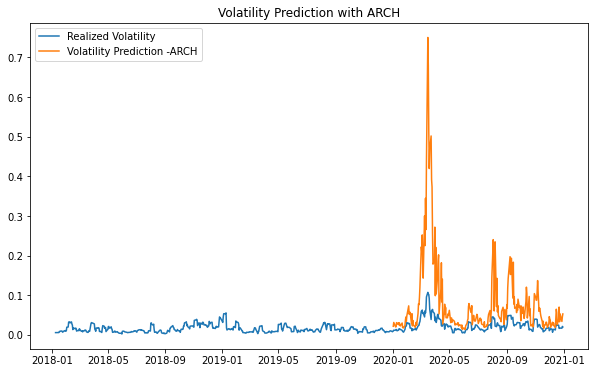

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] /100,
         label='Volatility Prediction -ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()